# Exploratory Data Analysis: Raw HTML Files

This notebook analyzes the raw HTML files to identify:
1. **Dynamically rendered pages** - SPAs, heavy JavaScript frameworks
2. **Anomalies** - errors, redirects, empty pages, captchas, etc.
3. **HTML characteristics** - size, structure, content quality
4. **Token counts** - using tiktoken for LLM context estimation

## Imports

In [9]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
import tiktoken

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline

print('All libraries imported successfully!')

All libraries imported successfully!


## Analysis Helper Functions

In [10]:
def detect_spa_frameworks(html: str, soup: BeautifulSoup) -> dict:
    """Detect Single Page Application frameworks and heavy JS usage"""
    indicators = {
        'react': False, 'vue': False, 'angular': False,
        'next_js': False, 'nuxt': False, 'svelte': False, 'generic_spa': False,
    }
    if re.search(r'react|__NEXT_DATA__|_reactRoot|data-reactroot', html, re.I):
        indicators['react'] = True
    if re.search(r'__NEXT_DATA__|next\\.js', html, re.I):
        indicators['next_js'] = True
    if re.search(r'vue\\.js|__NUXT__|v-app|v-if|v-for', html, re.I):
        indicators['vue'] = True
    if re.search(r'__NUXT__|nuxt', html, re.I):
        indicators['nuxt'] = True
    if re.search(r'ng-app|ng-controller|angular\\.js|ng-version', html, re.I):
        indicators['angular'] = True
    if re.search(r'svelte', html, re.I):
        indicators['svelte'] = True
    root_divs = soup.find_all('div', id=re.compile(r'^(root|app|__next)$', re.I))
    if root_divs and len(soup.get_text(strip=True)) < 500:
        indicators['generic_spa'] = True
    return indicators

def detect_dynamic_rendering(html: str, soup: BeautifulSoup) -> dict:
    """Detect signs of dynamic/client-side rendering"""
    script_tags = soup.find_all('script')
    text_content = soup.get_text(strip=True)
    text_ratio = len(text_content) / len(html) if len(html) > 0 else 0
    loading_indicators = bool(re.search(
        r'loading|please wait|enabling javascript|javascript is required|js required',
        text_content[:1000], re.I
    ))
    return {
        'script_count': len(script_tags),
        'external_script_count': len([s for s in script_tags if s.get('src')]),
        'text_to_html_ratio': round(text_ratio, 3),
        'loading_indicators': loading_indicators,
        'noscript_warning': len(' '.join([tag.get_text() for tag in soup.find_all('noscript')])) > 50,
        'json_ld_count': len(soup.find_all('script', type='application/ld+json')),
        'has_hydration_data': bool(re.search(r'__INITIAL_STATE__|__PRELOADED_STATE__|window\\.__DATA__', html)),
        'likely_dynamic': (len(script_tags) > 10 and text_ratio < 0.1) or loading_indicators
    }

def detect_anomalies(html: str, soup: BeautifulSoup) -> dict:
    """Detect various anomalies in HTML"""
    anomalies = {
        'empty_page': False, 'error_page': False, 'redirect_page': False,
        'login_required': False, 'captcha': False, 'robots_blocked': False,
        'malformed_html': False, 'encoding_issues': False,
    }
    text_content = soup.get_text(strip=True).lower()
    if len(text_content) < 100:
        anomalies['empty_page'] = True
    error_patterns = [r'404|not found', r'403|forbidden', r'500|internal server error',
                      r'502|bad gateway', r'503|service unavailable', r'error occurred']
    for pattern in error_patterns:
        if re.search(pattern, text_content):
            anomalies['error_page'] = True
            break
    if re.search(r'redirect|redirecting|you will be redirected', text_content):
        anomalies['redirect_page'] = True
    if re.search(r'login|sign in|authentication required|please log in', text_content[:500]):
        anomalies['login_required'] = True
    if re.search(r'captcha|recaptcha|verify you are human|security check', text_content):
        anomalies['captcha'] = True
    if re.search(r'robot|bot|crawler|automated access|rate limit', text_content[:1000]):
        anomalies['robots_blocked'] = True
    if not soup.find('html') or not soup.find('body'):
        anomalies['malformed_html'] = True
    if re.search(r'�|&#\\d+;&#\\d+;&#\\d+;', html):
        anomalies['encoding_issues'] = True
    return anomalies

def analyze_html_structure(soup: BeautifulSoup) -> dict:
    """Analyze HTML structure and characteristics"""
    meta_tags = soup.find_all('meta')
    return {
        'div': len(soup.find_all('div')), 'span': len(soup.find_all('span')),
        'p': len(soup.find_all('p')), 'a': len(soup.find_all('a')),
        'img': len(soup.find_all('img')), 'table': len(soup.find_all('table')),
        'form': len(soup.find_all('form')), 'input': len(soup.find_all('input')),
        'iframe': len(soup.find_all('iframe')),
        'semantic_count': sum(len(soup.find_all(tag)) for tag in ['article', 'section', 'nav', 'header', 'footer', 'main', 'aside']),
        'style_tags': len(soup.find_all('style')),
        'link_tags': len(soup.find_all('link', rel='stylesheet')),
        'meta_count': len(meta_tags),
        'has_viewport': any(m.get('name') == 'viewport' for m in meta_tags),
        'has_description': any(m.get('name') == 'description' for m in meta_tags),
        'has_charset': any(m.get('charset') for m in meta_tags),
    }

def analyze_content_quality(html: str, soup: BeautifulSoup) -> dict:
    """Analyze content quality metrics"""
    text_content = soup.get_text(separator=' ', strip=True)
    words = text_content.split()
    word_count = len(words)
    unique_words = len(set(w.lower() for w in words if len(w) > 3))
    links = soup.find_all('a', href=True)
    return {
        'word_count': word_count,
        'char_count': len(text_content),
        'unique_words': unique_words,
        'vocab_richness': round(unique_words / word_count if word_count > 0 else 0, 3),
        'total_links': len(links),
        'internal_links': len([l for l in links if l.get('href', '').startswith(('/', '#'))]),
        'external_links': len([l for l in links if l.get('href', '').startswith('http')]),
        'header_count': len(soup.find_all(re.compile(r'^h[1-6]$'))),
        'list_count': len(soup.find_all(['ul', 'ol'])),
    }

def analyze_single_html(html_path: Path, manifest_entry: dict) -> dict:
    """Analyze a single HTML file"""
    try:
        with open(html_path, 'r', encoding='utf-8', errors='replace') as f:
            html = f.read()
    except Exception as e:
        return {'id': manifest_entry['id'], 'error': str(e), 'file_size': 0}
    
    soup = BeautifulSoup(html, 'html.parser')
    result = {
        'id': manifest_entry['id'], 'url': manifest_entry['url'],
        'domain': manifest_entry['domain'], 'category': manifest_entry['category'],
        'file_size': len(html),
    }
    result['spa_frameworks'] = detect_spa_frameworks(html, soup)
    result['dynamic_rendering'] = detect_dynamic_rendering(html, soup)
    result['anomalies'] = detect_anomalies(html, soup)
    result['structure'] = analyze_html_structure(soup)
    result['content'] = analyze_content_quality(html, soup)
    return result

print('Analysis functions loaded!')

Analysis functions loaded!


## Run Analysis on Raw HTML Files

In [11]:
# Load manifest
manifest_path = Path('../data/raw_html/dataset_manifest.json')
with open(manifest_path) as f:
    manifest = json.load(f)

print(f'Found {len(manifest)} HTML files')

# Analyze each file
results = []
for entry in tqdm(manifest, desc='Analyzing HTML files'):
    html_path = Path('..') / entry['html_file']
    result = analyze_single_html(html_path, entry)
    results.append(result)

# Generate summary and flagged files
def summarize_findings(results):
    sizes = [r['file_size'] for r in results if 'file_size' in r]
    spa_counts = Counter()
    for r in results:
        if 'spa_frameworks' in r:
            for fw, detected in r['spa_frameworks'].items():
                if detected: spa_counts[fw] += 1
    dynamic_count = sum(1 for r in results if 'dynamic_rendering' in r and r['dynamic_rendering'].get('likely_dynamic'))
    anomaly_counts = Counter()
    for r in results:
        if 'anomalies' in r:
            for anomaly, detected in r['anomalies'].items():
                if detected: anomaly_counts[anomaly] += 1
    text_ratios = [r['dynamic_rendering']['text_to_html_ratio'] for r in results if 'dynamic_rendering' in r]
    return {
        'total_files': len(results),
        'file_size_stats': {'min': min(sizes), 'max': max(sizes), 'mean': sum(sizes)/len(sizes), 'median': sorted(sizes)[len(sizes)//2]},
        'spa_frameworks': dict(spa_counts),
        'dynamic_rendering_count': dynamic_count,
        'anomalies': dict(anomaly_counts),
        'text_ratio_stats': {'min': min(text_ratios), 'max': max(text_ratios), 'mean': sum(text_ratios)/len(text_ratios)},
        'category_distribution': dict(Counter(r['category'] for r in results if 'category' in r)),
    }

summary = summarize_findings(results)
detailed = results

# Generate flagged files
flagged = []
for r in results:
    flags = []
    if 'spa_frameworks' in r and any(r['spa_frameworks'].values()):
        flags.append(f'SPA: {", ".join([k for k, v in r["spa_frameworks"].items() if v])}')
    if 'dynamic_rendering' in r and r['dynamic_rendering'].get('likely_dynamic'):
        flags.append('Dynamic rendering detected')
    if 'anomalies' in r:
        active = [k for k, v in r['anomalies'].items() if v]
        if active: flags.append(f'Anomalies: {", ".join(active)}')
    if flags:
        flagged.append({'id': r['id'], 'url': r['url'], 'domain': r['domain'], 'flags': flags, 'file_size': r.get('file_size', 0)})

print(f'\nAnalyzed {len(results)} files')
print(f'Dynamic pages: {summary["dynamic_rendering_count"]}')
print(f'Flagged files: {len(flagged)}')

Found 100 HTML files


Analyzing HTML files: 100%|██████████| 100/100 [00:03<00:00, 26.58it/s]


Analyzed 100 files
Dynamic pages: 44
Flagged files: 69


## 1. File Size Distribution

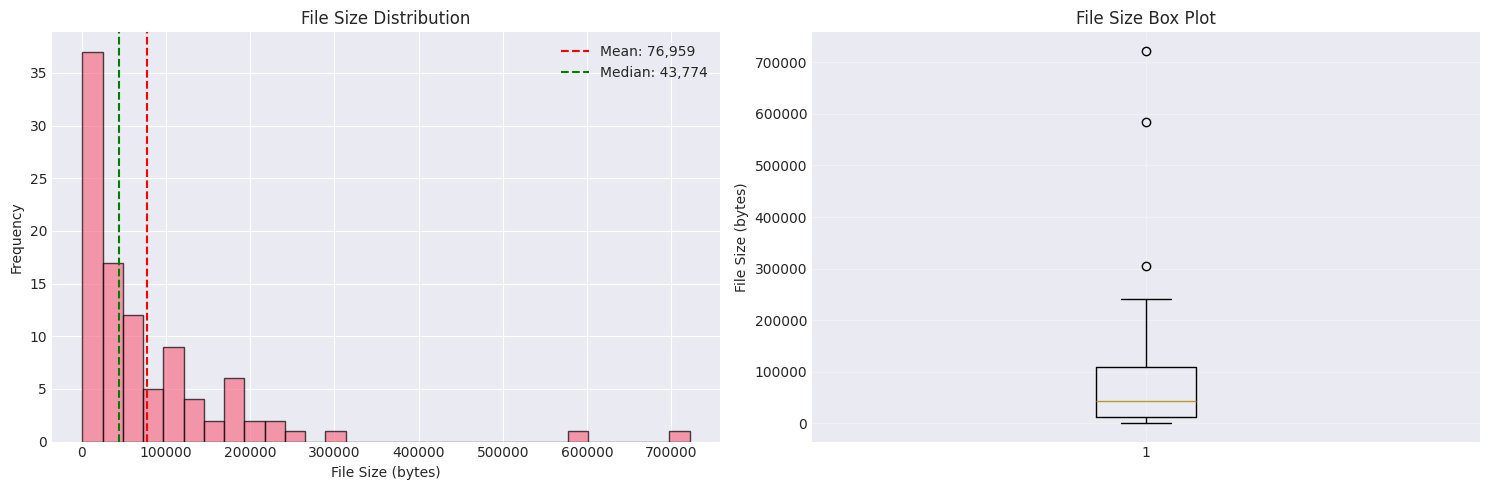

File Size Statistics:
  Min: 781 bytes
  Max: 721,940 bytes
  Mean: 76,959 bytes
  Median: 43,774 bytes


In [12]:
file_sizes = [d['file_size'] for d in detailed]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(file_sizes, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('File Size (bytes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('File Size Distribution')
axes[0].axvline(np.mean(file_sizes), color='red', linestyle='--', label=f'Mean: {np.mean(file_sizes):,.0f}')
axes[0].axvline(np.median(file_sizes), color='green', linestyle='--', label=f'Median: {np.median(file_sizes):,.0f}')
axes[0].legend()

axes[1].boxplot(file_sizes, vert=True)
axes[1].set_ylabel('File Size (bytes)')
axes[1].set_title('File Size Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'File Size Statistics:')
print(f'  Min: {min(file_sizes):,} bytes')
print(f'  Max: {max(file_sizes):,} bytes')
print(f'  Mean: {np.mean(file_sizes):,.0f} bytes')
print(f'  Median: {np.median(file_sizes):,.0f} bytes')

## 2. Dynamic Rendering Analysis

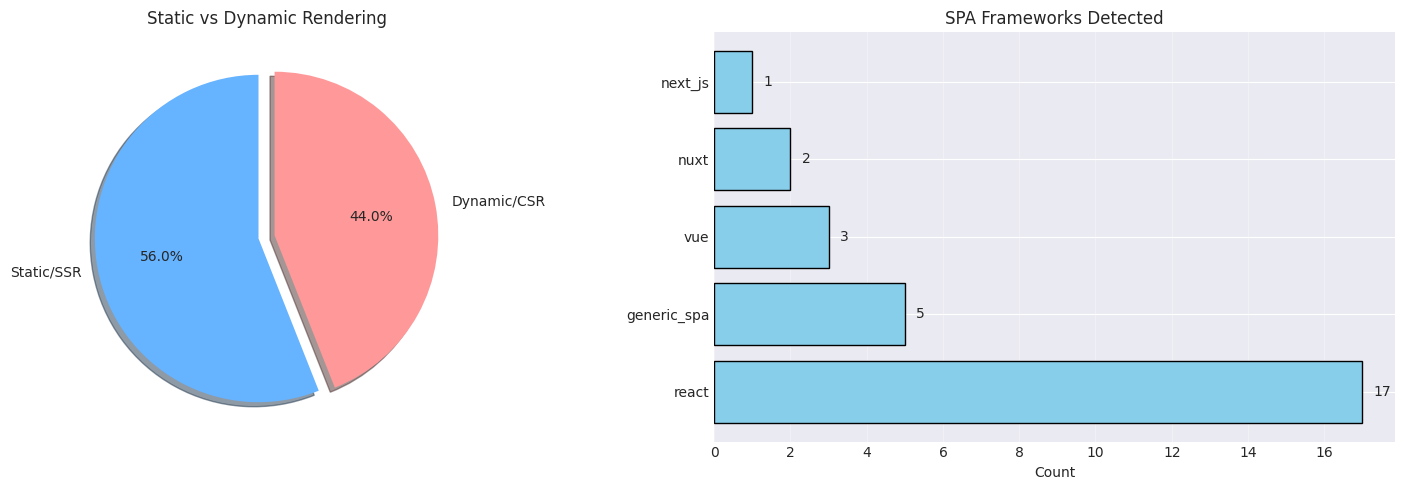

Dynamic Rendering Summary:
  Dynamic pages: 44 (44.0%)
  Static pages: 56 (56.0%)
\nFramework breakdown:
  react: 17
  generic_spa: 5
  vue: 3
  nuxt: 2
  next_js: 1


In [13]:
dynamic_count = summary['dynamic_rendering_count']
static_count = summary['total_files'] - dynamic_count

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
labels = ['Static/SSR', 'Dynamic/CSR']
sizes = [static_count, dynamic_count]
colors = ['#66b3ff', '#ff9999']
axes[0].pie(sizes, explode=(0.05, 0.05), labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].set_title('Static vs Dynamic Rendering')

# SPA Frameworks
spa_data = summary['spa_frameworks']
frameworks = list(spa_data.keys())
counts = list(spa_data.values())
axes[1].barh(frameworks, counts, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Count')
axes[1].set_title('SPA Frameworks Detected')
axes[1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(counts):
    axes[1].text(v + 0.3, i, str(v), va='center')

plt.tight_layout()
plt.show()

print(f'Dynamic Rendering Summary:')
print(f'  Dynamic pages: {dynamic_count} ({dynamic_count/summary["total_files"]*100:.1f}%)')
print(f'  Static pages: {static_count} ({static_count/summary["total_files"]*100:.1f}%)')
print(f'\\nFramework breakdown:')
for fw, count in spa_data.items():
    print(f'  {fw}: {count}')

## 3. Anomalies Analysis

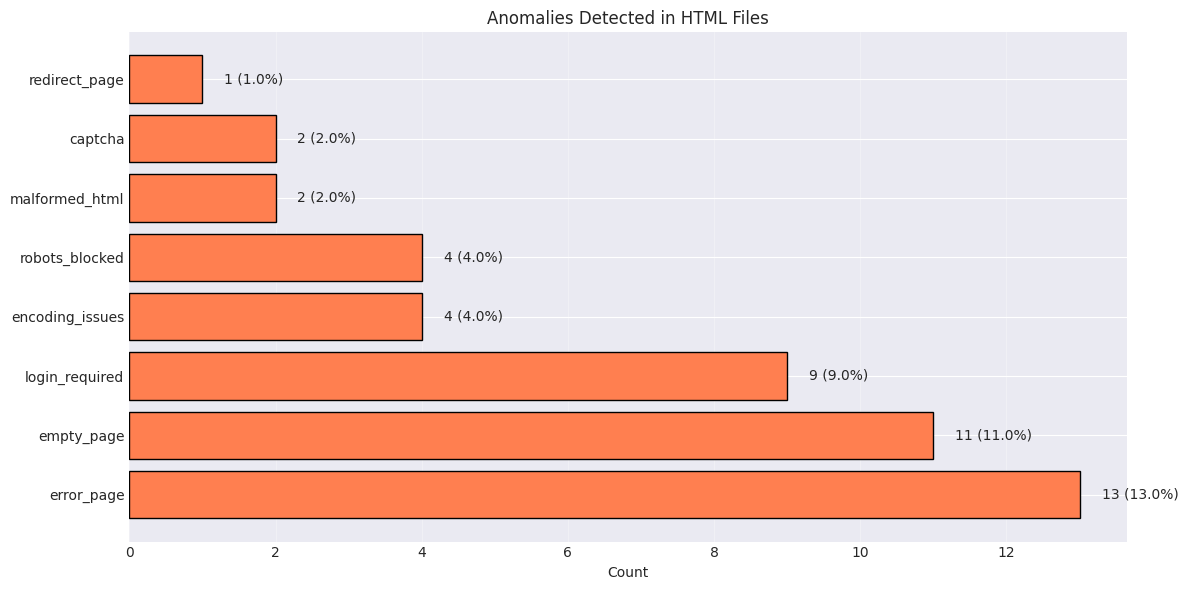

Anomalies Summary:
  Total anomaly instances: 46
\nBreakdown:
  error_page: 13 (13.0%)
  empty_page: 11 (11.0%)
  login_required: 9 (9.0%)
  encoding_issues: 4 (4.0%)
  robots_blocked: 4 (4.0%)
  malformed_html: 2 (2.0%)
  captcha: 2 (2.0%)
  redirect_page: 1 (1.0%)


In [14]:
anomaly_data = summary['anomalies']
anomaly_types = list(anomaly_data.keys())
anomaly_counts = list(anomaly_data.values())

sorted_indices = np.argsort(anomaly_counts)[::-1]
anomaly_types_sorted = [anomaly_types[i] for i in sorted_indices]
anomaly_counts_sorted = [anomaly_counts[i] for i in sorted_indices]

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(anomaly_types_sorted, anomaly_counts_sorted, color='coral', edgecolor='black')
ax.set_xlabel('Count')
ax.set_title('Anomalies Detected in HTML Files')
ax.grid(True, alpha=0.3, axis='x')

for i, (v, atype) in enumerate(zip(anomaly_counts_sorted, anomaly_types_sorted)):
    percentage = v / summary['total_files'] * 100
    ax.text(v + 0.3, i, f'{v} ({percentage:.1f}%)', va='center')

plt.tight_layout()
plt.show()

print('Anomalies Summary:')
print(f'  Total anomaly instances: {sum(anomaly_counts)}')
print('\\nBreakdown:')
for atype, count in zip(anomaly_types_sorted, anomaly_counts_sorted):
    print(f'  {atype}: {count} ({count/summary["total_files"]*100:.1f}%)')

## 4. Token Count Analysis (using tiktoken)

In [15]:
# Initialize tiktoken encoder (cl100k_base for GPT-4)
encoding = tiktoken.get_encoding('cl100k_base')

# Calculate token counts
token_data = []
print('Calculating token counts...')
for entry in tqdm(manifest, desc='Tokenizing HTML'):
    html_path = Path('..') / entry['html_file']
    try:
        with open(html_path, 'r', encoding='utf-8', errors='replace') as f:
            html_content = f.read()
        tokens = encoding.encode(html_content)
        token_data.append({
            'id': entry['id'],
            'url': entry['url'],
            'domain': entry['domain'],
            'file_size': len(html_content),
            'token_count': len(tokens),
            'tokens_per_byte': len(tokens) / len(html_content) if len(html_content) > 0 else 0
        })
    except Exception as e:
        print(f'Error processing {entry["id"]}: {e}')

token_df = pd.DataFrame(token_data)

print(f'\\nToken Count Statistics:')
print(f'  Min: {token_df["token_count"].min():,} tokens')
print(f'  Max: {token_df["token_count"].max():,} tokens')
print(f'  Mean: {token_df["token_count"].mean():,.0f} tokens')
print(f'  Median: {token_df["token_count"].median():,.0f} tokens')

# Context limits
context_limits = {'4K': 4096, '8K': 8192, '16K': 16384, '32K': 32768, '128K': 131072, '200K': 200000}
print(f'\\nFiles exceeding context limits:')
for name, limit in context_limits.items():
    count = (token_df['token_count'] > limit).sum()
    pct = count / len(token_df) * 100
    print(f'  > {name} ({limit:,} tokens): {count} files ({pct:.1f}%)')

Calculating token counts...


Tokenizing HTML: 100%|██████████| 100/100 [00:01<00:00, 98.43it/s]

\nToken Count Statistics:
  Min: 199 tokens
  Max: 231,970 tokens
  Mean: 25,643 tokens
  Median: 11,680 tokens
\nFiles exceeding context limits:
  > 4K (4,096 tokens): 76 files (76.0%)
  > 8K (8,192 tokens): 62 files (62.0%)
  > 16K (16,384 tokens): 43 files (43.0%)
  > 32K (32,768 tokens): 23 files (23.0%)
  > 128K (131,072 tokens): 2 files (2.0%)
  > 200K (200,000 tokens): 2 files (2.0%)


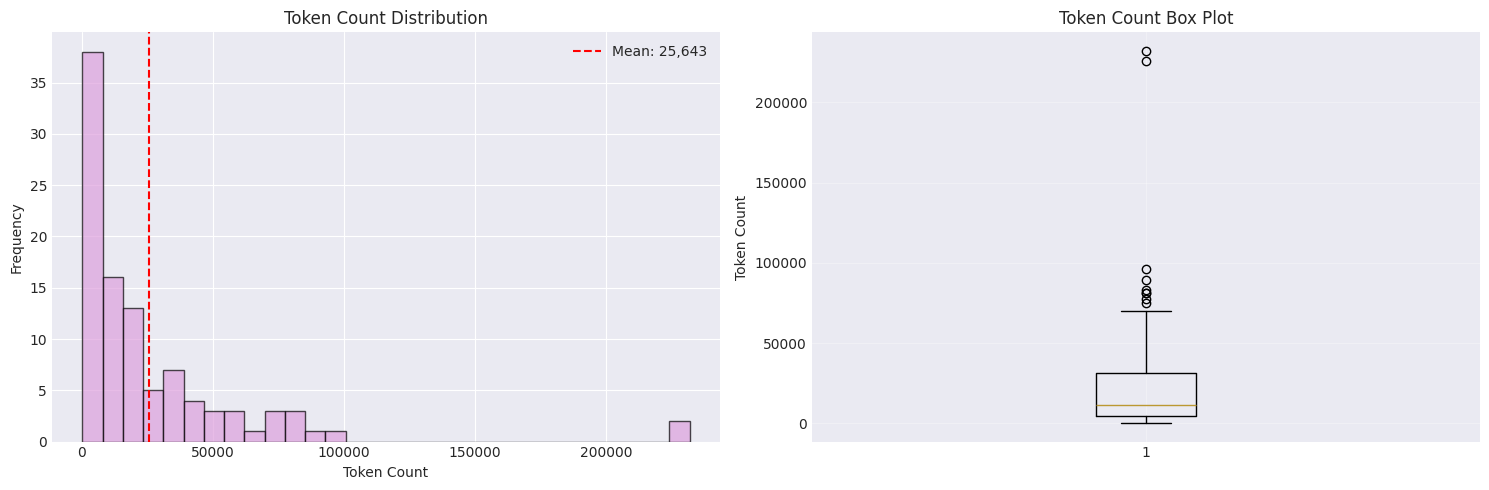

In [18]:
# Visualize token counts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Token count distribution
axes[0].hist(token_df['token_count'], bins=30, edgecolor='black', alpha=0.7, color='plum')
axes[0].set_xlabel('Token Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Token Count Distribution')
axes[0].axvline(token_df['token_count'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {token_df["token_count"].mean():,.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(token_df['token_count'], vert=True)
axes[1].set_ylabel('Token Count')
axes[1].set_title('Token Count Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()